In [13]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt


In [14]:
url0 = 'https://raw.githubusercontent.com/BDonadelli/Finance-playground/refs/heads/main/data/'

url  = {'ibra50' :url0+'Cart_IBr50.csv',
        'ibra100':url0+'Cart_IBr100.csv',
        'idiv'   :url0+'Cart_Idiv.csv',
        'ibov'   :url0+'Cart_Ibov.csv',
        'small'  :url0+'Cart_Small.csv'
}
indice = pd.read_csv(url['ibov'] ,
                     sep=';' , decimal=',' , thousands='.' ,
                      skipfooter=2 , encoding='utf-8',
                     index_col=False , engine='python')

indice

,Código,Ação,Tipo,Qtde. Teórica,Part. (%)
0,VALE3,VALE,ON NM,4270903023,11962
1,PETR4,PETROBRAS,PN N2,4431132660,8253
2,ITUB4,ITAUUNIBANCO,PN EDJ N1,4792902422,7727
3,PETR3,PETROBRAS,ON N2,2255782178,4608
4,BBAS3,BRASIL,ON NM,2842613858,3938
...,...,...,...,...,...
80,AZUL4,AZUL,PN ES N2,326872005,66
81,PCAR3,P.ACUCAR-CBD,ON NM,462534972,61
82,PETZ3,PETZ,ON NM,293689428,61
83,LWSA3,LWSA,ON NM,389635155,57


In [15]:
df_ibov = indice['Código']
tickers = [codigo + '.SA' for codigo in df_ibov.tolist()]

In [16]:
print(f"Total de ações do IBOV: {len(tickers)}")


Total de ações do IBOV: 85


[*********************100%***********************]  85 of 85 completed


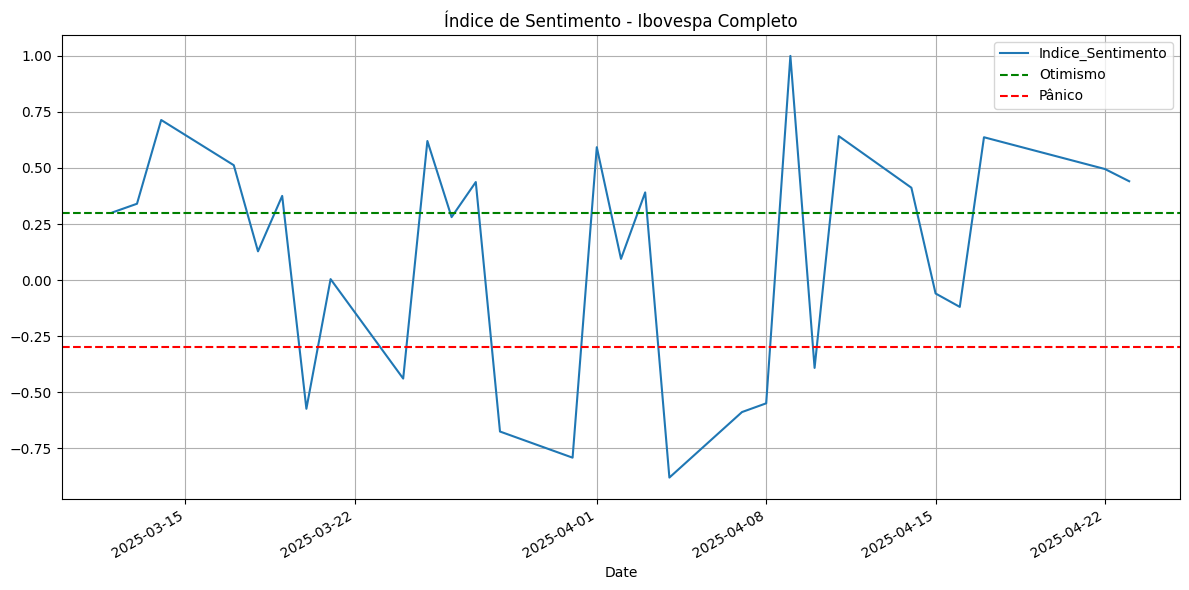

In [17]:
# 2. Baixar dados históricos
periodo = '30d'
data = yf.download(tickers, period=periodo, interval='1d', group_by='ticker', auto_adjust=True, threads=True)

# 3. Calcular índice de sentimento ao longo do tempo
datas = data.index
df_resultado = pd.DataFrame(index=datas[1:])
indices = []

for i in range(1, len(datas)):
    dia_atual = datas[i]
    dia_anterior = datas[i - 1]

    soma_num = 0
    soma_den = 0

    for ticker in tickers:
        try:
            preco_atual = data[ticker]['Close'].loc[dia_atual]
            preco_anterior = data[ticker]['Close'].loc[dia_anterior]
            volume = data[ticker]['Volume'].loc[dia_atual]

            retorno = (preco_atual - preco_anterior) / preco_anterior
            sinal = 1 if retorno > 0 else (-1 if retorno < 0 else 0)

            soma_num += volume * sinal
            soma_den += abs(volume * sinal)

        except Exception:
            continue

    indice = soma_num / soma_den if soma_den != 0 else 0
    indices.append(indice)

df_resultado['Indice_Sentimento'] = indices

# 4. Visualizar
df_resultado.plot(title='Índice de Sentimento - Ibovespa Completo', figsize=(12, 6), legend=False)
plt.axhline(0.3, color='green', linestyle='--', label='Otimismo')
plt.axhline(-0.3, color='red', linestyle='--', label='Pânico')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


In [18]:
import plotly.io as pio
pio.renderers.default = 'vscode'    #@param ['svg', 'colab', 'vscode' ]

In [19]:
import plotly.graph_objects as go


# 5. Gauge: último valor
indice_atual = df_resultado['Indice_Sentimento'].iloc[-1]
indice_ontem = df_resultado['Indice_Sentimento'].iloc[-2]
variacao = indice_atual - indice_ontem
data_ult = df_resultado.index[-1].strftime('%Y-%m-%d')

fig = go.Figure(go.Indicator(
    mode="gauge+number+delta",
    value=indice_atual,
    delta={'reference': indice_ontem, 'increasing': {'color': "green"}, 'decreasing': {'color': "red"}},
    number={'font': {'size': 48}},
    gauge={
        'axis': {'range': [0, 1], 'tickvals': [0, 0.2, 0.4, 0.6, 0.8, 1], 
                 'ticktext': ['Pânico', 'Medo', 'Neutro', 'Neutro', 'Confiante', 'Otimismo']},
        'bar': {'color': 'brown', 'thickness': 0.3},
        'bgcolor': "lightgray",
        'steps': [
            {'range': [0, 0.2], 'color': '#e6e6e6'},
            {'range': [0.2, 0.4], 'color': '#d9d9d9'},
            {'range': [0.4, 0.6], 'color': '#cccccc'},
            {'range': [0.6, 0.8], 'color': '#bfbfbf'},
            {'range': [0.8, 1.0], 'color': '#b3b3b3'}
        ],
    },
    title={'text': f"Índice de Pânico e Otimismo<br><span style='font-size:0.9em'>Data: {data_ult}</span>"}
))

fig.update_layout(height=500, margin={'t': 80, 'b': 0})
fig.show()
